In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp

from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/desi-examples/imaging_systematics'))
from plot_healpix_map import plot_map

sys.path.append(os.path.expanduser('~/git/desi-targets/useful'))
from isdes import get_isdes

In [2]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
repeats = 64  # number of MC sims for each random point
n_randoms_catalogs = 32
truth_density = 63745.
randoms_density = 2500.

In [4]:
bad_pixels = Table.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/ism_mask/bad_pixels_v1_512_ring.fits')['HPXPIXEL']

npix = hp.nside2npix(512)
tmp = np.zeros(npix)
tmp[bad_pixels] = 1.
tmp = hp.ud_grade(tmp, 128, order_in='RING', order_out='RING')
# bad_pixels_128 = np.where(tmp!=0)[0]
bad_pixels_128 = np.where(tmp>0.2)[0]

In [5]:
nside = 128

cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/mc/20230201/mc_elg_randoms_elgmask_v1_healpix_{}.fits'.format(nside)))
print(len(cat))

mask = ~np.in1d(cat['HPXPIXEL'], bad_pixels_128)
cat = cat[mask]
print(len(cat))

pix_area = hp.nside2pixarea(nside, degrees=True)
cat['pix_frac'] = cat['n_randoms']/(randoms_density*n_randoms_catalogs*pix_area)
mask = cat['pix_frac'] > 0.5
cat = cat[mask]
print(len(cat))

# Remove the pixels straddling north and south
mask = (np.abs(cat['DEC']-32.375)>0.2) | (cat['RA']<90) | (cat['RA']>300)
cat = cat[mask]
print(len(cat))

96232
80759
80156
79962


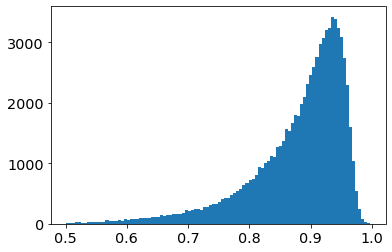

In [6]:
plt.hist(cat['pix_frac'], 100);

In [7]:
# Simulated ELG density (per sq. deg.)
cat['mc_density'] = cat['elglop']/(randoms_density*n_randoms_catalogs*repeats/truth_density)/(cat['pix_frac']*pix_area)

2032.2855720670436


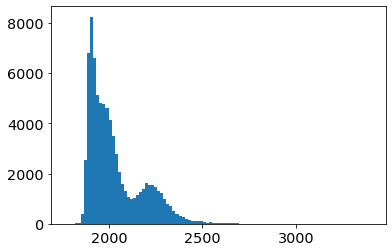

In [8]:
print(np.mean(cat['mc_density']))
plt.hist(cat['mc_density'], 100);

In [9]:
mask_north = (cat['DEC']>=32.375) & (cat['RA']>90) & (cat['RA']<300)
mask_south = (~mask_north)
mask_south_good = mask_south & (cat['DEC']>-29)
mc_mean_density_north = np.mean(cat['mc_density'][mask_north])
mc_mean_density_south = np.mean(cat['mc_density'][mask_south_good])
print('{:.1f}  {:.1f}  {:.3f}'.format(mc_mean_density_north, mc_mean_density_south, mc_mean_density_north/mc_mean_density_south))
cat['mc_relative_density'] = cat['mc_density']/mc_mean_density_south

2248.0  1984.5  1.133


1.0240893427797824


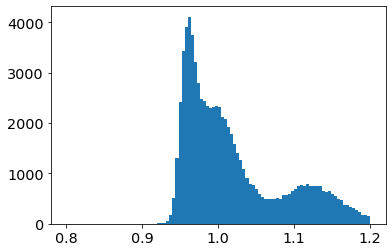

In [10]:
print(np.mean(cat['mc_relative_density']))
plt.hist(cat['mc_relative_density'], 100, range=(0.8, 1.2));

cat 79962


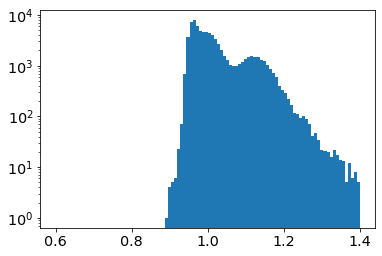

In [11]:
plt.hist(cat['mc_relative_density'], 100, range=(0.6, 1.4), log=True);
mask = (cat['mc_relative_density']>0.5) & (cat['mc_relative_density']<2)
cat = cat[mask]
print('cat', len(cat))

Done! 00:00:02


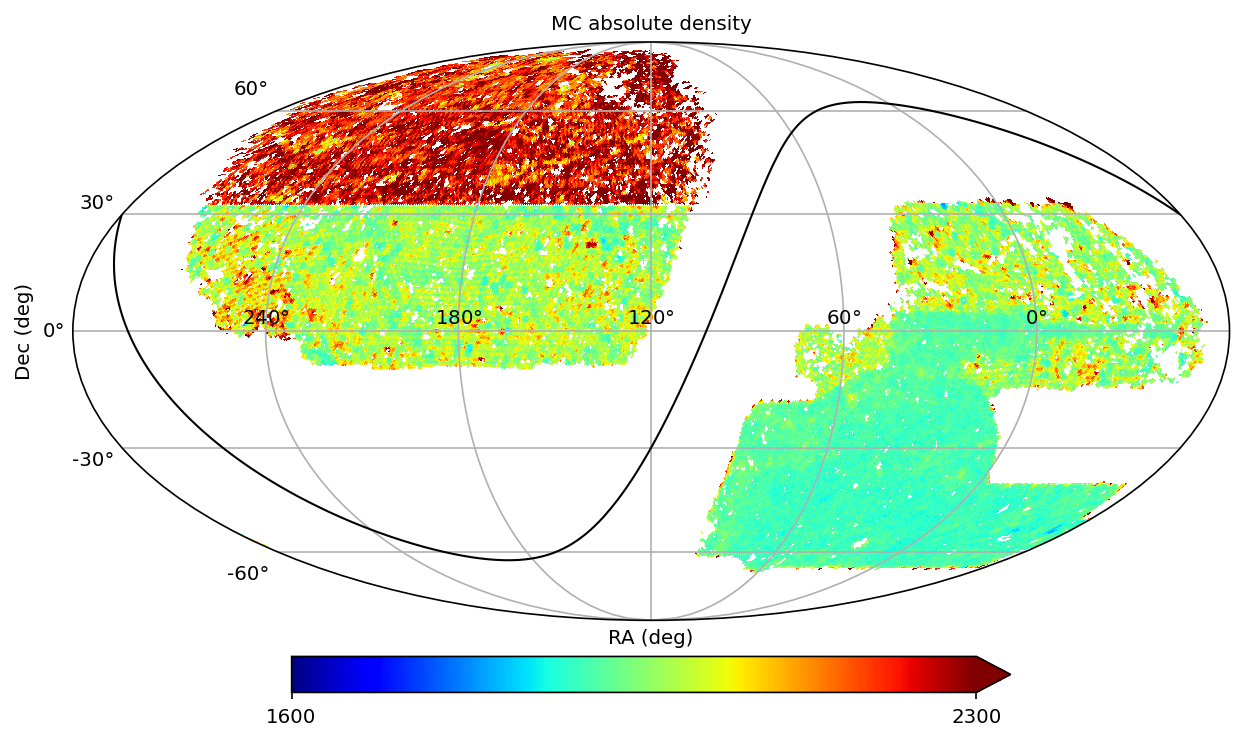

In [12]:
plot_map(nside, cat['HPXPIXEL'], cat['mc_density'], xsize=1500, dpi=150, title='MC absolute density',
         vmin=1600, vmax=2300, save_path='tmp.png', show=False)
Image("tmp.png")

Done! 00:00:02


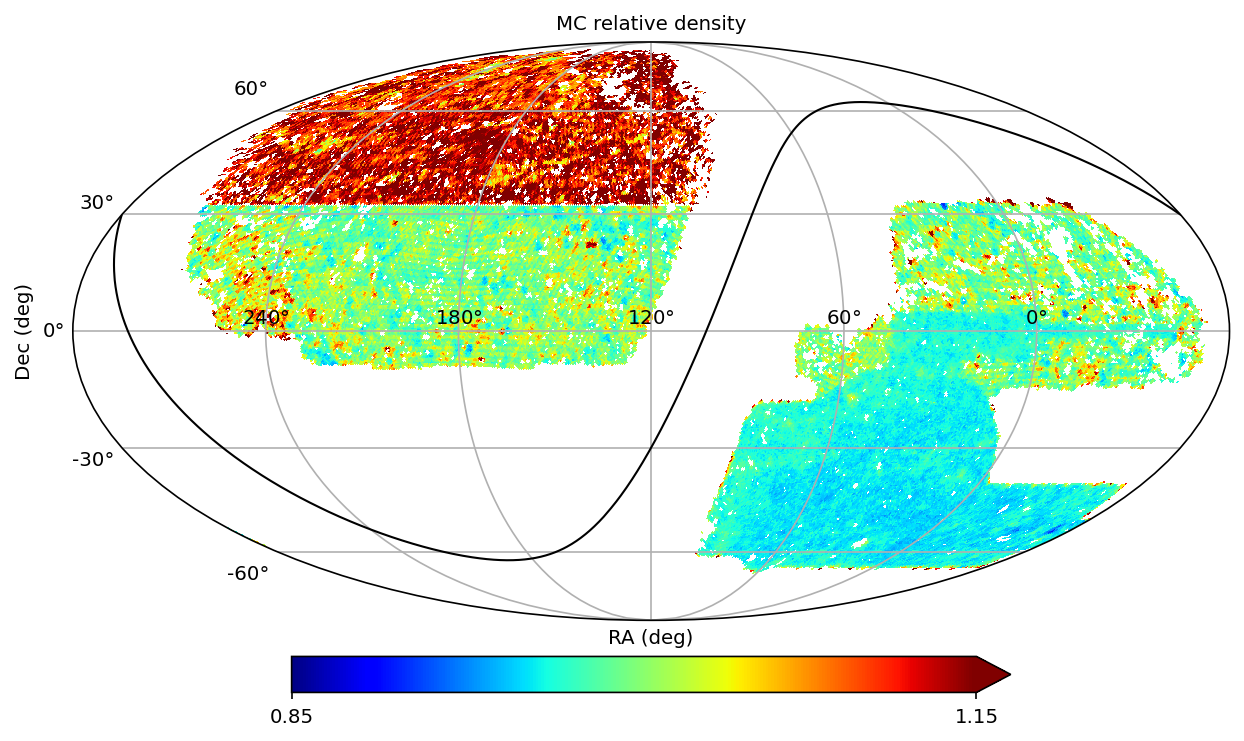

In [13]:
plot_map(nside, cat['HPXPIXEL'], cat['mc_relative_density'], xsize=1500, dpi=150, title='MC relative density',
         vmin=0.85, vmax=1.15, save_path='tmp.png', show=False)
Image("tmp.png")

Done! 00:00:02


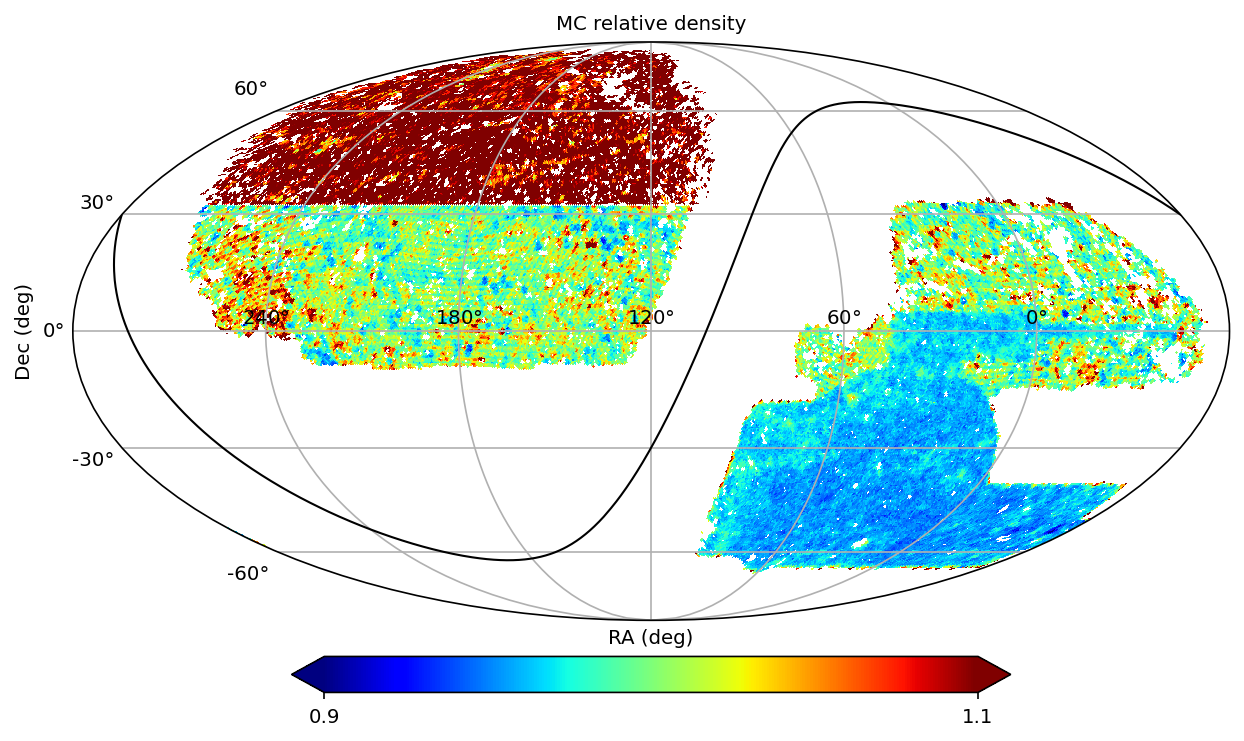

In [14]:
plot_map(nside, cat['HPXPIXEL'], cat['mc_relative_density'], xsize=1500, dpi=150, title='MC relative density',
         vmin=0.9, vmax=1.1, save_path='tmp.png', show=False)
Image("tmp.png")

Done! 00:00:02


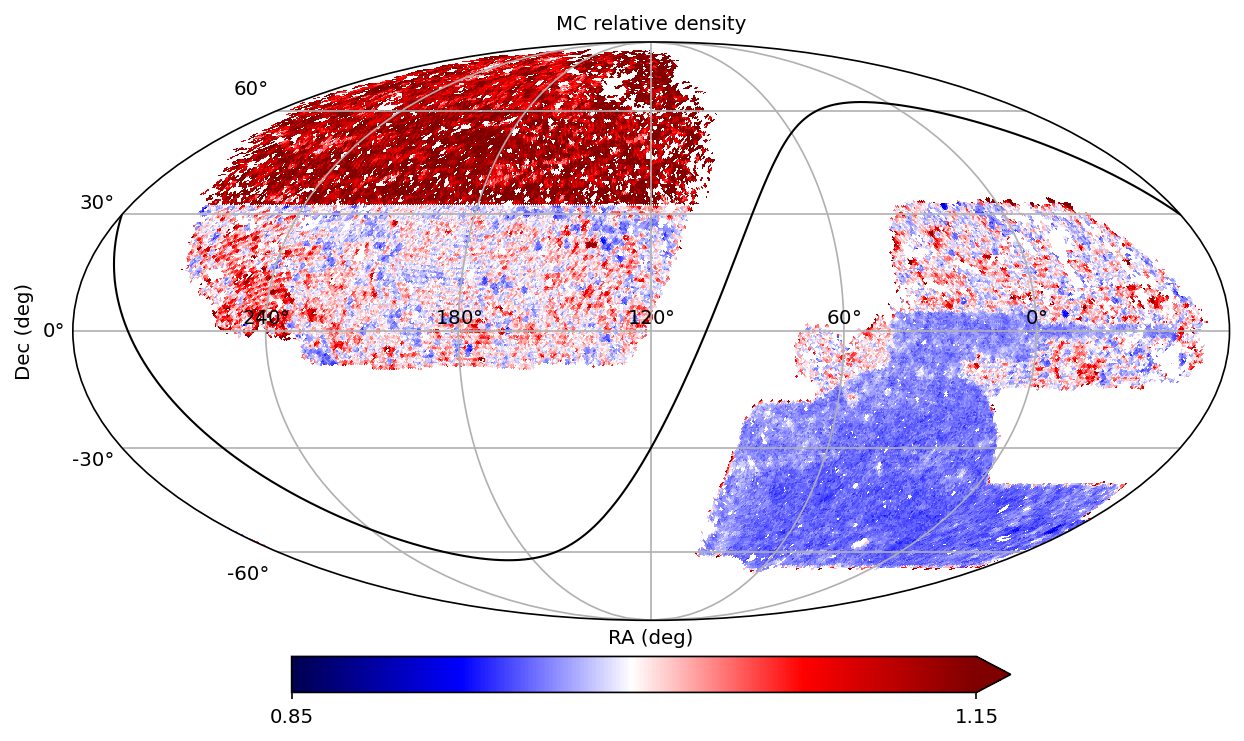

In [15]:
plot_map(nside, cat['HPXPIXEL'], cat['mc_relative_density'], xsize=1500, dpi=150, title='MC relative density', cmap='seismic',
         vmin=0.85, vmax=1.15, save_path='tmp.png', show=False)
Image("tmp.png")

128 Healpix size = 0.20982 sq deg
96213
Area = 17032.9 sq deg
0.8554221999765711
maps 80325
Done! 00:00:02


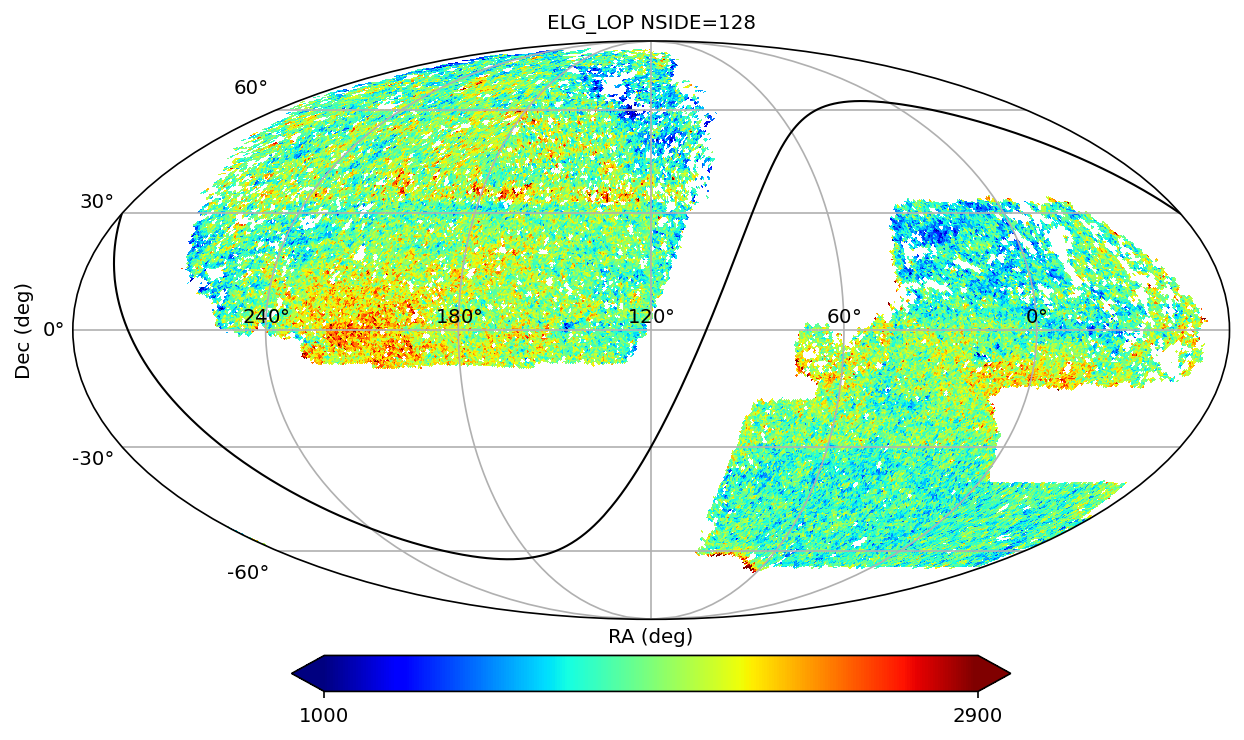

In [16]:
target_ver_str = '1.1.1'
pixmap_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/randoms_stats/0.49.0/resolve/combined'
target_densities_dir = '/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/density_maps/{}/resolve'.format(target_ver_str)
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
print(nside, 'Healpix size = {:.5f} sq deg'.format(pix_area))


vrange_dict = {'BGS_ANY': {64: [800, 2000], 128: [650, 2150], 256: [200, 2600], 512: [-200, 3000]},
               'BGS_BRIGHT': {64: [500, 1200], 128: [350, 1350], 256: [200, 1500], 512: [-200, 1800]},
               'LRG': {64: [300, 900], 128: [200, 1000], 256: [100, 1100], 512: [-200, 1400]},
               'ELG': {64: [1200, 3600], 128: [1200, 3600], 256: [1100, 3700], 512: [600, 4200]},
               'ELG_LOP': {64: [1000, 2900], 128: [1000, 2900], 256: [900, 3000], 512: [500, 3400]},
               'QSO': {64: [150, 450], 128: [150, 450], 256: [0, 600], 512: [-200, 800]},
               }


target_class = 'ELG_LOP'
min_nobs = 1
min_pix_frac = 0.4  # minimum fraction of pixel area to be used

maskbits_dict = {'LRG': [], 'ELG': [], 'ELG_LOP': [], 'QSO': [1, 8, 9, 11, 12, 13], 'BGS_ANY': [1, 13], 'BGS_BRIGHT': [1, 13]}
custom_mask_dict = {'LRG': 'lrgmask_v1.1', 'ELG': 'elgmask_v1', 'ELG_LOP': 'elgmask_v1', 'QSO': '', 'BGS_ANY': '', 'BGS_BRIGHT': ''}

maskbits = maskbits_dict[target_class]
custom_mask_name = custom_mask_dict[target_class]

mask_str = ''.join([str(tmp) for tmp in maskbits])
if custom_mask_name!='':
    mask_str += '_' + custom_mask_name

target_class = target_class.lower()
maps_dict = {}

for region in ['BASS+MzLS', 'DECaLS', 'DES']:

    if region=='BASS+MzLS':
        field = 'north'
    else:
        field = 'south'

    density = Table.read(os.path.join(target_densities_dir, 'density_map_{}_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format(target_class, field, nside, min_nobs, mask_str)))
    maps = Table.read(os.path.join(pixmap_dir, 'pixmap_{}_nside_{}_minobs_{}_maskbits_{}.fits'.format(field, nside, min_nobs, mask_str)))
    maps = maps[maps['n_randoms']>0]
    maps = join(maps, density[['HPXPIXEL', 'n_targets']], join_type='outer', keys='HPXPIXEL').filled(0)

    # Load stellar density map
    stardens = np.load('/global/cfs/cdirs/desi/users/rongpu/useful/healpix_maps/pixweight-dr7.1-0.22.0_stardens_{}_ring.npy'.format(nside))
    maps['stardens'] = stardens[maps['HPXPIXEL']]
    maps['stardens_log'] = np.log10(maps['stardens'])

    if field=='south':
        isdes = get_isdes(maps['RA'], maps['DEC'], nside)
        if region=='DES':
            maps = maps[isdes]
        else:
            maps = maps[~isdes]
    maps['region'] = region[:3]
    maps_dict[region] = maps.copy()
            
maps_north = maps_dict['BASS+MzLS']
maps_south = vstack([maps_dict['DECaLS'], maps_dict['DES']])

########## Combine the two maps; proper handling of overlapping pixels ##########

pix_overlap = np.intersect1d(maps_north['HPXPIXEL'], maps_south['HPXPIXEL'])
mask = np.in1d(maps_north['HPXPIXEL'], pix_overlap)
maps_overlap_north = maps_north[mask]
maps_north = maps_north[~mask]
mask = np.in1d(maps_south['HPXPIXEL'], pix_overlap)
maps_overlap_south = maps_south[mask]
maps_south = maps_south[~mask]

maps_overlap_north.sort('HPXPIXEL')
maps_overlap_south.sort('HPXPIXEL')

maps_overlap = maps_overlap_south.copy()
maps_overlap['n_targets'] = maps_overlap_north['n_targets'] + maps_overlap_south['n_targets']
maps_overlap['FRACAREA'] = maps_overlap_north['FRACAREA'] + maps_overlap_south['FRACAREA']

maps = vstack([maps_north, maps_south, maps_overlap])

######################################################################

print(len(maps))

area = np.sum(maps['FRACAREA'])*pix_area
print('Area = {:.1f} sq deg'.format(area))

mask = maps['FRACAREA']>min_pix_frac
maps = maps[mask]

maps['density'] = maps['n_targets'] / (pix_area * maps['FRACAREA'])

mask = ~np.in1d(maps['HPXPIXEL'], bad_pixels_128)
print(np.sum(mask)/len(mask))
maps = maps[mask]
print('maps', len(maps))

plot_map(nside, maps['HPXPIXEL'], maps['density'],
         vmin=vrange_dict[target_class.upper()][nside][0], vmax=vrange_dict[target_class.upper()][nside][1],
         title='{} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

In [17]:
maps = join(maps, cat[['HPXPIXEL', 'mc_relative_density']], keys='HPXPIXEL', join_type='inner').filled(0)

Done! 00:00:02


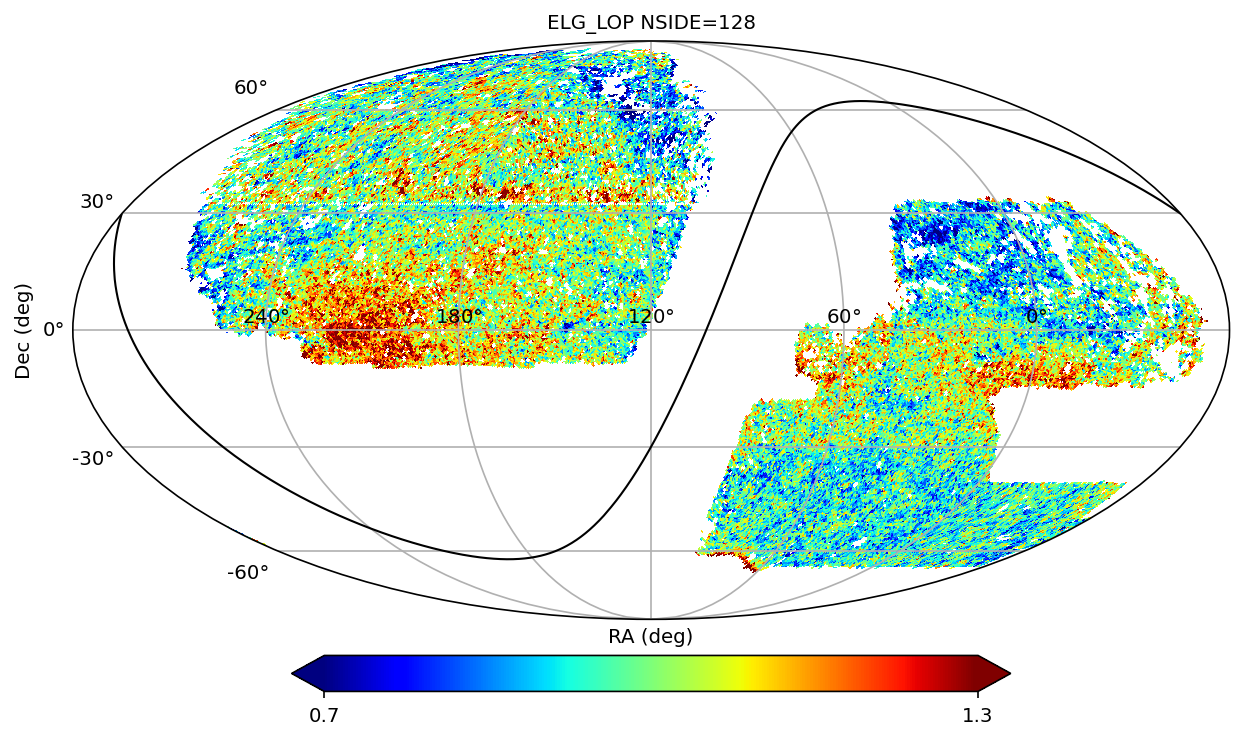

In [18]:
maps['relative_density'] = maps['density']/np.mean(maps['density'])

plot_map(nside, maps['HPXPIXEL'], maps['relative_density'],
         vmin=0.7, vmax=1.3,
         title='{} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

Done! 00:00:02


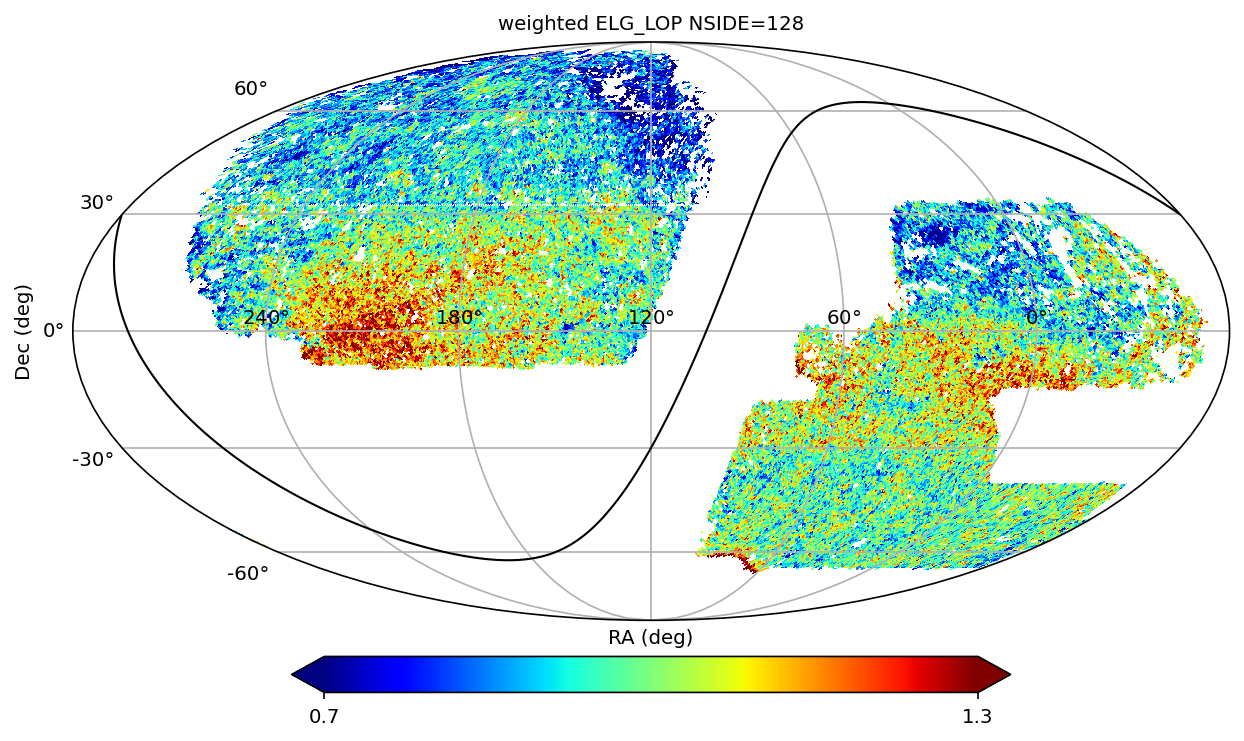

In [19]:
plot_map(nside, maps['HPXPIXEL'], maps['relative_density']/maps['mc_relative_density'],
         vmin=0.7, vmax=1.3,
         title='weighted {} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

Done! 00:00:02


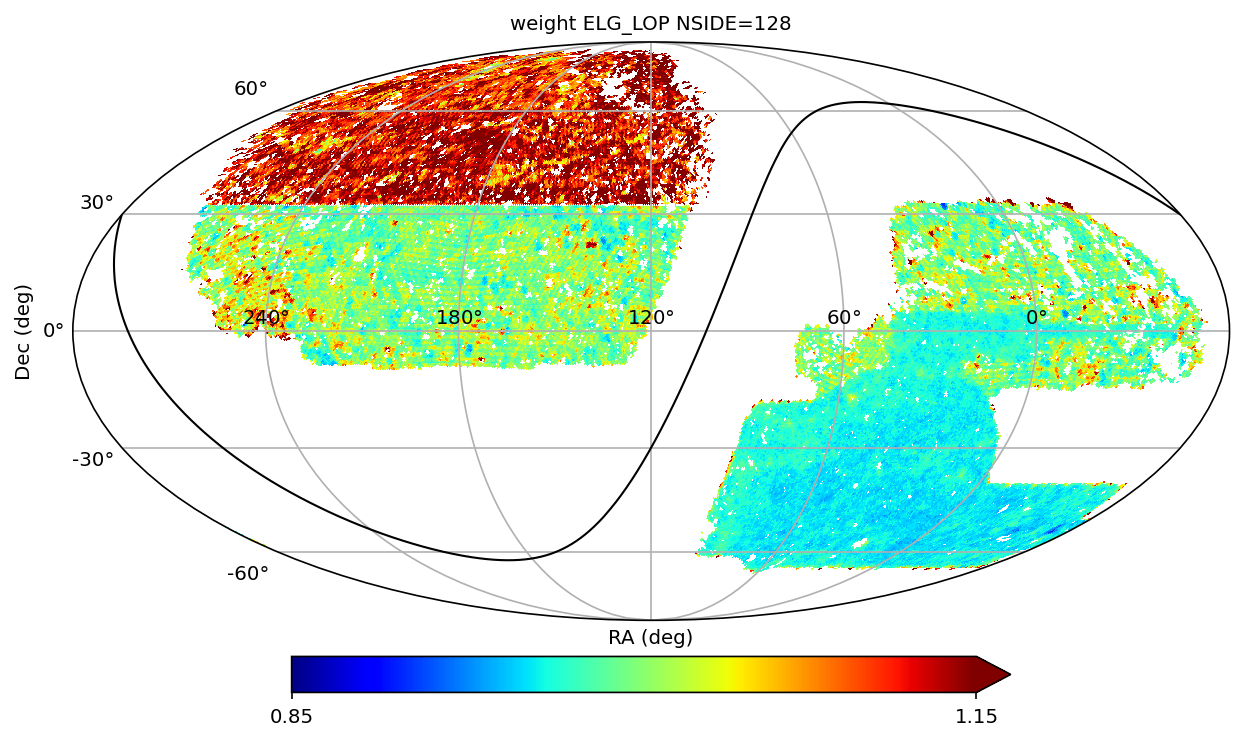

In [20]:
plot_map(nside, maps['HPXPIXEL'], maps['mc_relative_density'],
         vmin=0.85, vmax=1.15,
         title='weight {} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

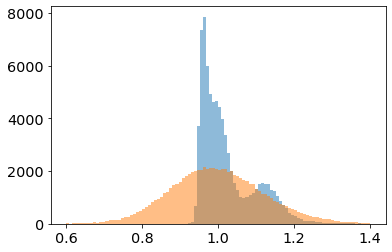

In [21]:
plt.hist(cat['mc_relative_density'], 100, range=(0.6, 1.4), alpha=0.5)
plt.hist(maps['density']/np.mean(maps['density']), 100, range=(0.6, 1.4), alpha=0.5)
plt.show()

--------

In [22]:
mask = maps['DEC']>-29  # Remove the southern part of DES
maps = maps[mask]

In [23]:
from scipy import stats

error_of_the_mean = lambda x: np.std(x)/np.sqrt(len(x))

def binned_mean(x, y, bin_edges=None, weights=None, minsize=30, nbins=30, percentiles=[0.5, 99.5]):
    if bin_edges is None:
        vmin, vmax = np.percentile(x, percentiles)
        bin_edges = np.linspace(vmin, vmax, nbins)
    if weights is None:
        weights = np.ones(len(x))
    bin_mean = np.zeros(len(bin_edges)-1)
    for index in range(len(bin_edges)-1):
        mask = (x>bin_edges[index]) & (x<=bin_edges[index+1])
        if np.sum(mask)<minsize:
            bin_mean[index]=np.nan
        else:
            bin_mean[index] = np.sum(y[mask]*weights[mask])/np.sum(weights[mask])    
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bin_edges)
    bin_error[np.isnan(bin_mean)] = np.nan
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    
    return bin_center, bin_edges, bin_mean, bin_error

In [24]:
var_range = 0.15

xnames = ['stardens', 'EBV', 'psfdepth_w1mag', 'galdepth_gmag', 'galdepth_rmag', 'galdepth_zmag', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
xlabels = ['GAIA stellar density [deg$^{-2}$]', 'E(B-V)', 'W1-band PSF depth [mag]', 'g-band galaxy depth [mag]', 'r-band galaxy depth [mag]', 'z-band galaxy depth [mag]', 'g-band PSF size [arcsec]', 'r-band PSF size [arcsec]', 'z-band PSF size [arcsec]', ]
xlabels_ebv = ['GAIA stellar density [deg$^{-2}$]', 'E(B-V)', 'W1-band PSF depth - 0.184*E(B-V) [mag]', 'g-band galaxy depth - 3.214*E(B-V) [mag]', 'r-band galaxy depth - 2.165*E(B-V) [mag]', 'z-band galaxy depth - 1.211*E(B-V) [mag]', 'g-band PSF size [arcsec]', 'r-band PSF size [arcsec]', 'z-band PSF size [arcsec]', ]

bin_params = {}
bin_params['stardens'], bin_params['stardens_nbins'] = np.array([200, 3500]), 50
bin_params['stardens_log'], bin_params['stardens_log_nbins'] = np.array([2.3, 3.6]), 50
bin_params['EBV'], bin_params['EBV_nbins'] = np.array([0., 0.15]), 50
bin_params['galdepth_gmag'], bin_params['galdepth_gmag_nbins'] = np.array([23.85, 25.3]), 60
bin_params['galdepth_rmag'], bin_params['galdepth_rmag_nbins'] = np.array([23.2, 25.]), 60
bin_params['galdepth_zmag'], bin_params['galdepth_zmag_nbins'] = np.array([22.6, 23.75]), 60
bin_params['psfdepth_gmag'], bin_params['psfdepth_gmag_nbins'] = np.array([23.85+0.15, 25.3+0.35]), 60
bin_params['psfdepth_rmag'], bin_params['psfdepth_rmag_nbins'] = np.array([23.2+0.2, 25.+0.4]), 60
bin_params['psfdepth_zmag'], bin_params['psfdepth_zmag_nbins'] = np.array([22.6+0.2, 23.75+0.4]), 60
bin_params['psfdepth_w1mag'], bin_params['psfdepth_w1mag_nbins'] = np.array([21.2, 22.]), 50
bin_params['psfdepth_w2mag'], bin_params['psfdepth_w2mag_nbins'] = np.array([20.5, 21.8]), 50
bin_params['PSFSIZE_G'], bin_params['PSFSIZE_G_nbins'] = np.array([1.1, 2.5]), 50
bin_params['PSFSIZE_R'], bin_params['PSFSIZE_R_nbins'] = np.array([1.0, 2.3]), 50
bin_params['PSFSIZE_Z'], bin_params['PSFSIZE_Z_nbins'] = np.array([0.9, 1.9]), 50
bin_params['galdepth_gmag_ebv'], bin_params['galdepth_gmag_ebv_nbins'] = bin_params['galdepth_gmag'] - 0.1, 60
bin_params['galdepth_rmag_ebv'], bin_params['galdepth_rmag_ebv_nbins'] = bin_params['galdepth_rmag'] - 0.1, 60
bin_params['galdepth_zmag_ebv'], bin_params['galdepth_zmag_ebv_nbins'] = bin_params['galdepth_zmag'] - 0.05, 60
bin_params['psfdepth_w1mag_ebv'], bin_params['psfdepth_w1mag_ebv_nbins'] = bin_params['psfdepth_w1mag'], 60
bin_params['psfdepth_w2mag_ebv'], bin_params['psfdepth_w2mag_ebv_nbins'] = bin_params['psfdepth_w2mag'], 60
bin_params['psfdepth_gmag_ebv'], bin_params['psfdepth_gmag_ebv_nbins'] = bin_params['psfdepth_gmag'] - 0.1, 60
bin_params['psfdepth_rmag_ebv'], bin_params['psfdepth_rmag_ebv_nbins'] = bin_params['psfdepth_rmag'] - 0.1, 60
bin_params['psfdepth_zmag_ebv'], bin_params['psfdepth_zmag_ebv_nbins'] = bin_params['psfdepth_zmag'] - 0.05, 60
bin_params['psfdepth_w1mag_ebv'], bin_params['psfdepth_w1mag_ebv_nbins'] = bin_params['psfdepth_w1mag'], 50
bin_params['psfdepth_w2mag_ebv'], bin_params['psfdepth_w2mag_ebv_nbins'] = bin_params['psfdepth_w2mag'], 50

In [25]:
xnames, xlabels, xlabels_ebv, var_range = xnames, xlabels, xlabels_ebv, var_range

if nside>=512:
    minsize = 400
elif nside==256:
    minsize = 100
else:
    minsize = 50

area = np.sum(maps['FRACAREA'])*pix_area
mean_density = np.sum(maps['n_targets'])/area

__Measured density trends__

In [26]:
for ebv_corr in [False, True]:

    for index, xname in enumerate(xnames):

        if ebv_corr and ('depth' in xname):
            xname += '_ebv'
            xlabel = xlabels_ebv[index]
        else:
            xlabel = xlabels[index]

        bin_edges = np.linspace(*bin_params[xname], bin_params[xname+'_nbins'])

        bin_width = bin_edges[1]-bin_edges[0]
        histbin_edge = np.arange(bin_edges[0] - 2*bin_width, bin_edges[-1] + 2.1*bin_width, bin_width)
        xmin, xmax = bin_edges[0] - 2*bin_width, bin_edges[-1] + 2*bin_width

        # normalize the histograms to the histogram of the full sample
        bincount_max = np.max([np.histogram(maps[maps['region']==region[:3]][xname], bins=histbin_edge)[0].max() for region in ['BASS+MzLS', 'DECaLS', 'DES']])

        fig, ax = plt.subplots(figsize=(5.8, 4))

        for region, color in zip(['BASS+MzLS', 'DECaLS', 'DES'], ['C1', 'C0', 'C2']):

            maps_mask = maps['region']==region[:3]
            bin_center, _, bin_mean, bin_error = binned_mean(maps[xname][maps_mask], maps['density'][maps_mask]/mean_density, bin_edges=bin_edges, weights=maps['FRACAREA'][maps_mask], minsize=minsize)
            histbin_center = (histbin_edge[1:]+histbin_edge[:-1])/2
            bincount, _ = np.histogram(maps[xname][maps_mask], bins=histbin_edge)
            bincount = 0.8*var_range*bincount/bincount_max
            ax.errorbar(bin_center, bin_mean-1, yerr=bin_error, label=region, color=color)
            ax.hist(histbin_center, bins=histbin_edge, weights=bincount, alpha=0.3, color=color)

        ax.grid(alpha=0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(r'$N_\mathrm{gal}\ /\ \overline{N}_\mathrm{gal} - 1$')
        ax.axis([xmin, xmax, -var_range, var_range])
        if index==len(xnames)-1:
            plt.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig('tmp/{}_{}.png'.format(target_class, index+1))
        plt.close()

    if ebv_corr:
        plot_dir_path = os.path.join('plots/systematics_{}_{}_ebv_corr.png'.format(target_class, nside))
    else:
        plot_dir_path = os.path.join('plots/systematics_{}_{}.png'.format(target_class, nside))
    print(plot_dir_path)

    os.system('montage tmp/{}_{{1..{}}}.png -geometry 100% -tile 3x {}'.format(target_class, len(xnames), plot_dir_path))

plots/systematics_elg_lop_128.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


plots/systematics_elg_lop_128_ebv_corr.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


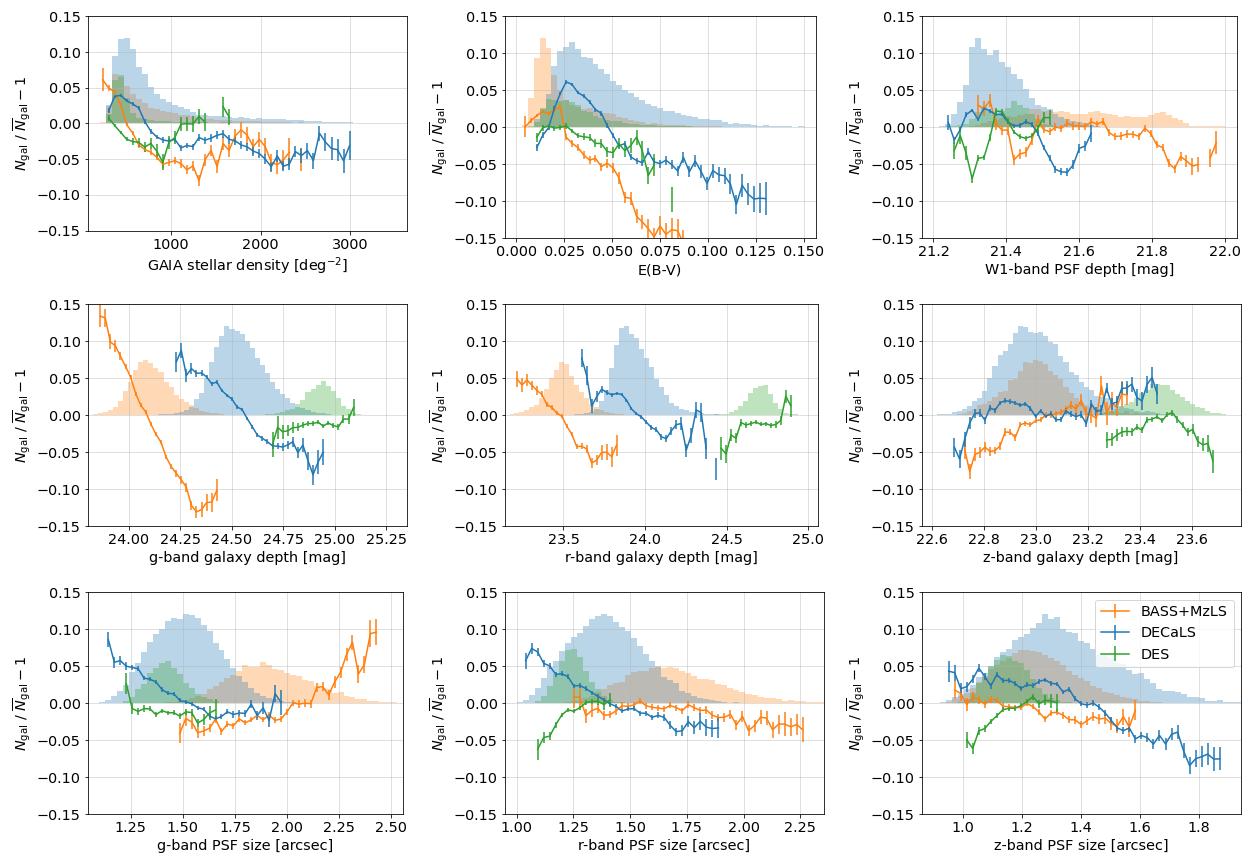

In [27]:
Image('plots/systematics_elg_lop_128.png')

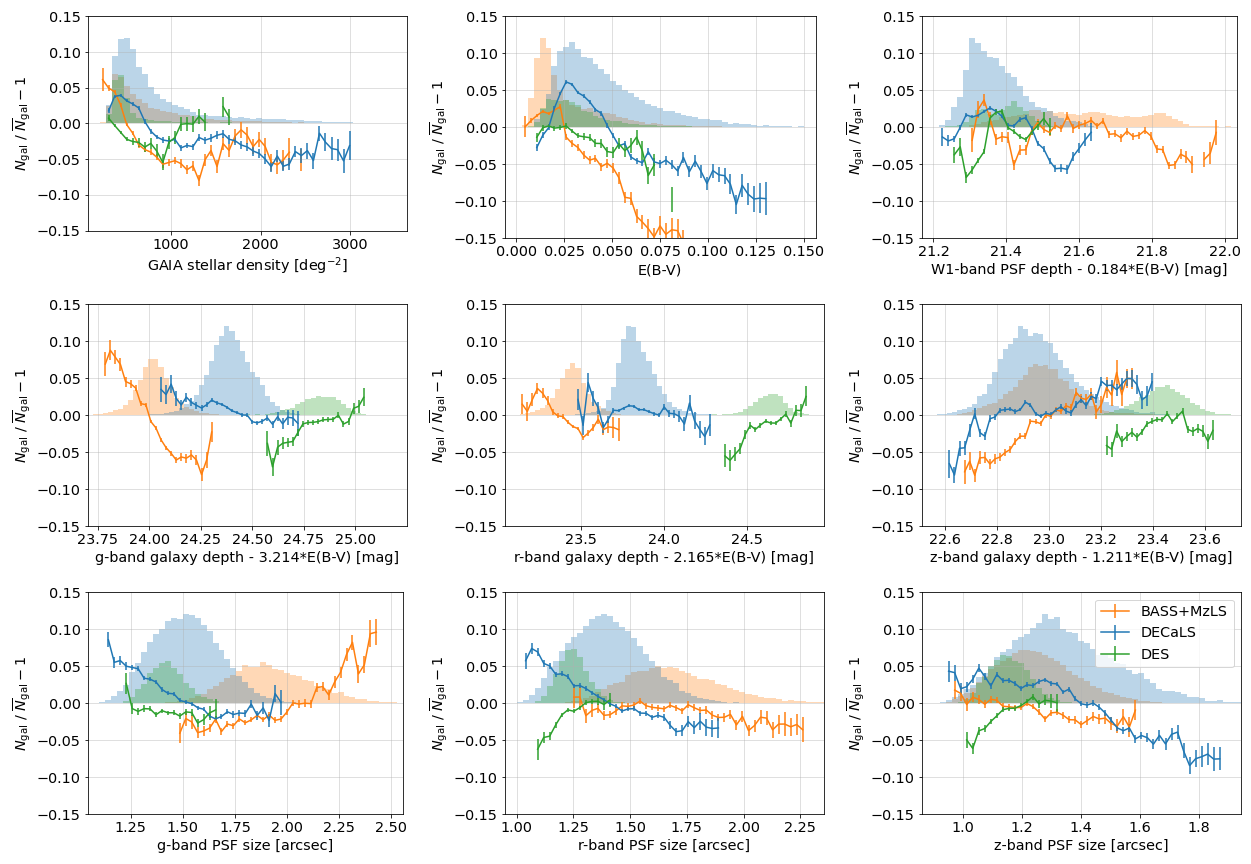

In [28]:
Image('plots/systematics_elg_lop_128_ebv_corr.png')

__Predicted density trends__

In [29]:
for ebv_corr in [False, True]:

    for index, xname in enumerate(xnames):

        if ebv_corr and ('depth' in xname):
            xname += '_ebv'
            xlabel = xlabels_ebv[index]
        else:
            xlabel = xlabels[index]

        bin_edges = np.linspace(*bin_params[xname], bin_params[xname+'_nbins'])

        bin_width = bin_edges[1]-bin_edges[0]
        histbin_edge = np.arange(bin_edges[0] - 2*bin_width, bin_edges[-1] + 2.1*bin_width, bin_width)
        xmin, xmax = bin_edges[0] - 2*bin_width, bin_edges[-1] + 2*bin_width

        # normalize the histograms to the histogram of the full sample
        bincount_max = np.max([np.histogram(maps[maps['region']==region[:3]][xname], bins=histbin_edge)[0].max() for region in ['BASS+MzLS', 'DECaLS', 'DES']])

        fig, ax = plt.subplots(figsize=(5.8, 4))

        for region, color in zip(['BASS+MzLS', 'DECaLS', 'DES'], ['C1', 'C0', 'C2']):

            maps_mask = maps['region']==region[:3]
            bin_center, _, bin_mean, bin_error = binned_mean(maps[xname][maps_mask], maps['mc_relative_density'][maps_mask], bin_edges=bin_edges, weights=maps['FRACAREA'][maps_mask], minsize=minsize)
            histbin_center = (histbin_edge[1:]+histbin_edge[:-1])/2
            bincount, _ = np.histogram(maps[xname][maps_mask], bins=histbin_edge)
            bincount = 0.8*var_range*bincount/bincount_max
            ax.errorbar(bin_center, bin_mean-1, yerr=bin_error, label=region, color=color)
            ax.hist(histbin_center, bins=histbin_edge, weights=bincount, alpha=0.3, color=color)

        ax.grid(alpha=0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(r'$N_\mathrm{gal}\ /\ \overline{N}_\mathrm{gal} - 1$')
        ax.axis([xmin, xmax, -var_range, var_range])
        if index==len(xnames)-1:
            plt.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig('tmp/{}_{}.png'.format(target_class, index+1))
        plt.close()

    if ebv_corr:
        plot_dir_path = os.path.join('plots/mc_{}_{}_ebv_corr.png'.format(target_class, nside))
    else:
        plot_dir_path = os.path.join('plots/mc_{}_{}.png'.format(target_class, nside))
    print(plot_dir_path)

    os.system('montage tmp/{}_{{1..{}}}.png -geometry 100% -tile 3x {}'.format(target_class, len(xnames), plot_dir_path))

plots/mc_elg_lop_128.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


plots/mc_elg_lop_128_ebv_corr.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


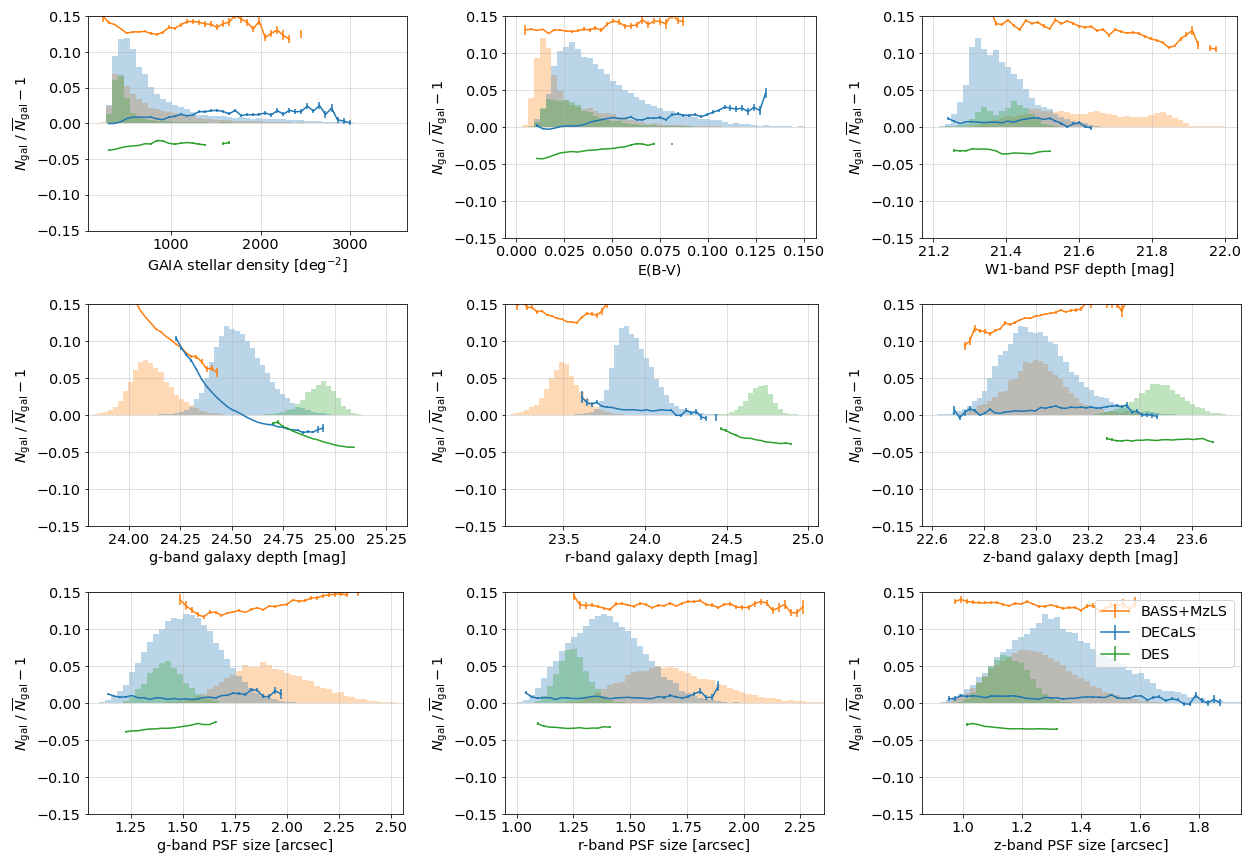

In [30]:
Image('plots/mc_elg_lop_128.png')

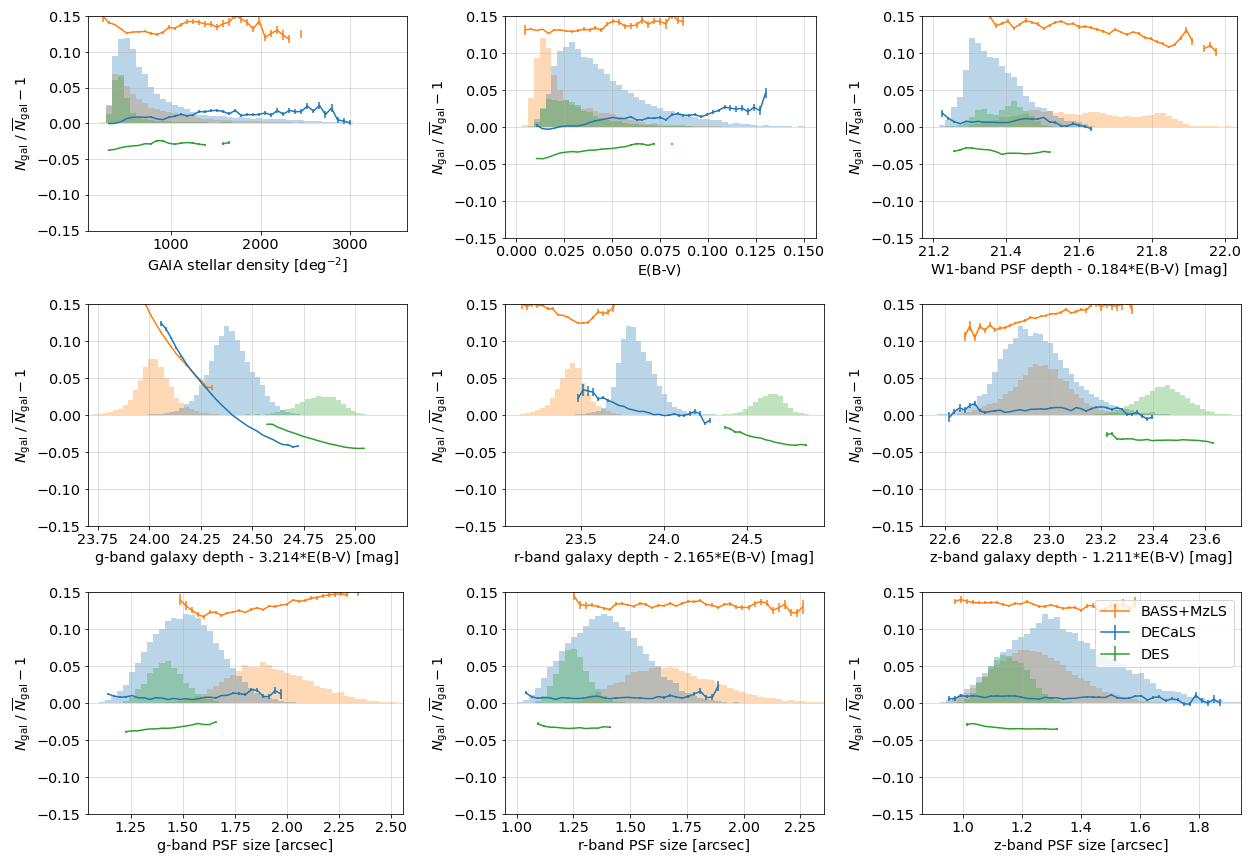

In [31]:
Image('plots/mc_elg_lop_128_ebv_corr.png')

__Measured density trends after model correction__

In [32]:
for ebv_corr in [False, True]:

    for index, xname in enumerate(xnames):

        if ebv_corr and ('depth' in xname):
            xname += '_ebv'
            xlabel = xlabels_ebv[index]
        else:
            xlabel = xlabels[index]

        bin_edges = np.linspace(*bin_params[xname], bin_params[xname+'_nbins'])

        bin_width = bin_edges[1]-bin_edges[0]
        histbin_edge = np.arange(bin_edges[0] - 2*bin_width, bin_edges[-1] + 2.1*bin_width, bin_width)
        xmin, xmax = bin_edges[0] - 2*bin_width, bin_edges[-1] + 2*bin_width

        # normalize the histograms to the histogram of the full sample
        bincount_max = np.max([np.histogram(maps[maps['region']==region[:3]][xname], bins=histbin_edge)[0].max() for region in ['BASS+MzLS', 'DECaLS', 'DES']])

        fig, ax = plt.subplots(figsize=(5.8, 4))

        for region, color in zip(['BASS+MzLS', 'DECaLS', 'DES'], ['C1', 'C0', 'C2']):

            maps_mask = maps['region']==region[:3]
            bin_center, _, bin_mean, bin_error = binned_mean(maps[xname][maps_mask], maps['density'][maps_mask]/maps['mc_relative_density'][maps_mask]/mean_density, bin_edges=bin_edges, weights=maps['FRACAREA'][maps_mask], minsize=minsize)
            histbin_center = (histbin_edge[1:]+histbin_edge[:-1])/2
            bincount, _ = np.histogram(maps[xname][maps_mask], bins=histbin_edge)
            bincount = 0.8*var_range*bincount/bincount_max
            ax.errorbar(bin_center, bin_mean-1, yerr=bin_error, label=region, color=color)
            ax.hist(histbin_center, bins=histbin_edge, weights=bincount, alpha=0.3, color=color)

        ax.grid(alpha=0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(r'$N_\mathrm{gal}\ /\ \overline{N}_\mathrm{gal} - 1$')
        ax.axis([xmin, xmax, -var_range, var_range])
        if index==len(xnames)-1:
            plt.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig('tmp/{}_{}.png'.format(target_class, index+1))
        plt.close()

    if ebv_corr:
        plot_dir_path = os.path.join('plots/mc_corrected_{}_{}_ebv_corr.png'.format(target_class, nside))
    else:
        plot_dir_path = os.path.join('plots/mc_corrected_{}_{}.png'.format(target_class, nside))
    print(plot_dir_path)

    os.system('montage tmp/{}_{{1..{}}}.png -geometry 100% -tile 3x {}'.format(target_class, len(xnames), plot_dir_path))

plots/mc_corrected_elg_lop_128.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


plots/mc_corrected_elg_lop_128_ebv_corr.png


montage: unable to read font `helvetica' @ error/annotate.c/RenderFreetype/1459.


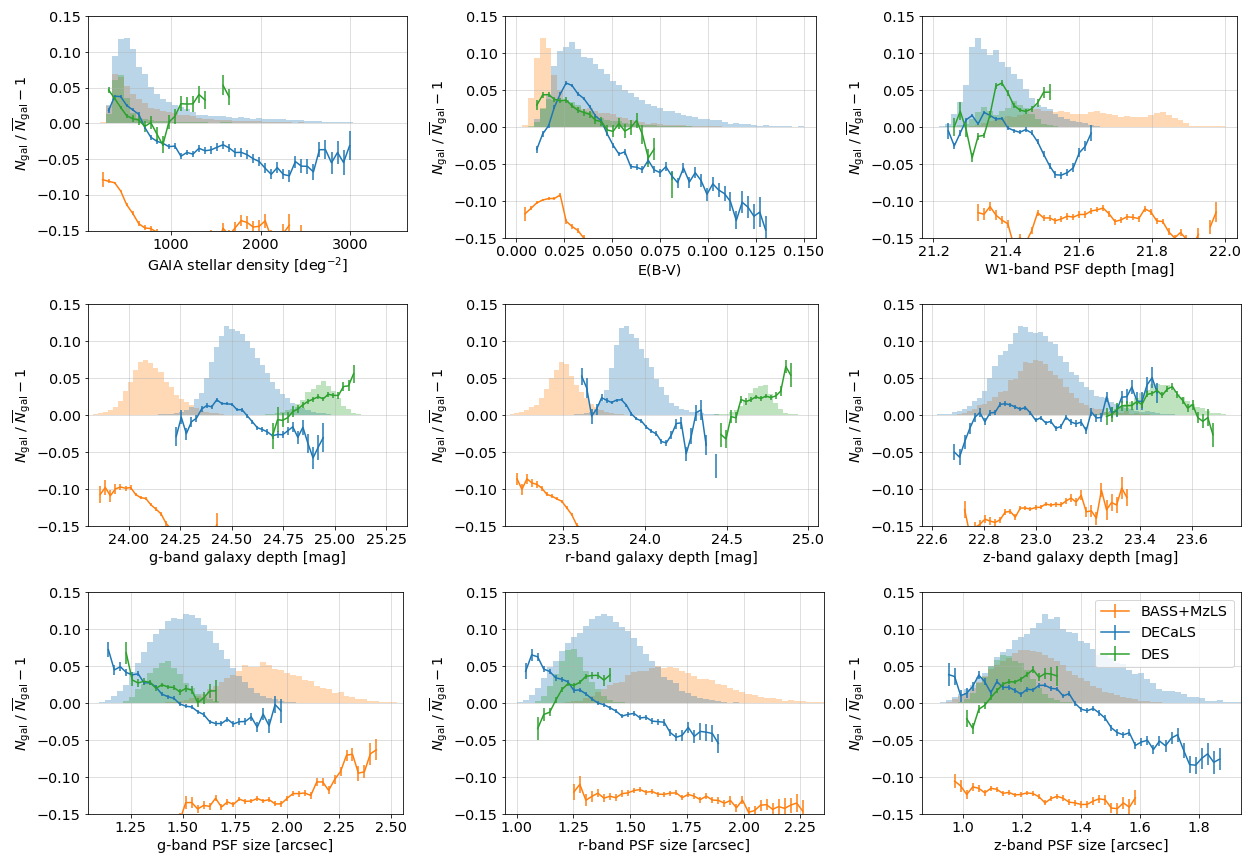

In [33]:
Image('plots/mc_corrected_elg_lop_128.png')

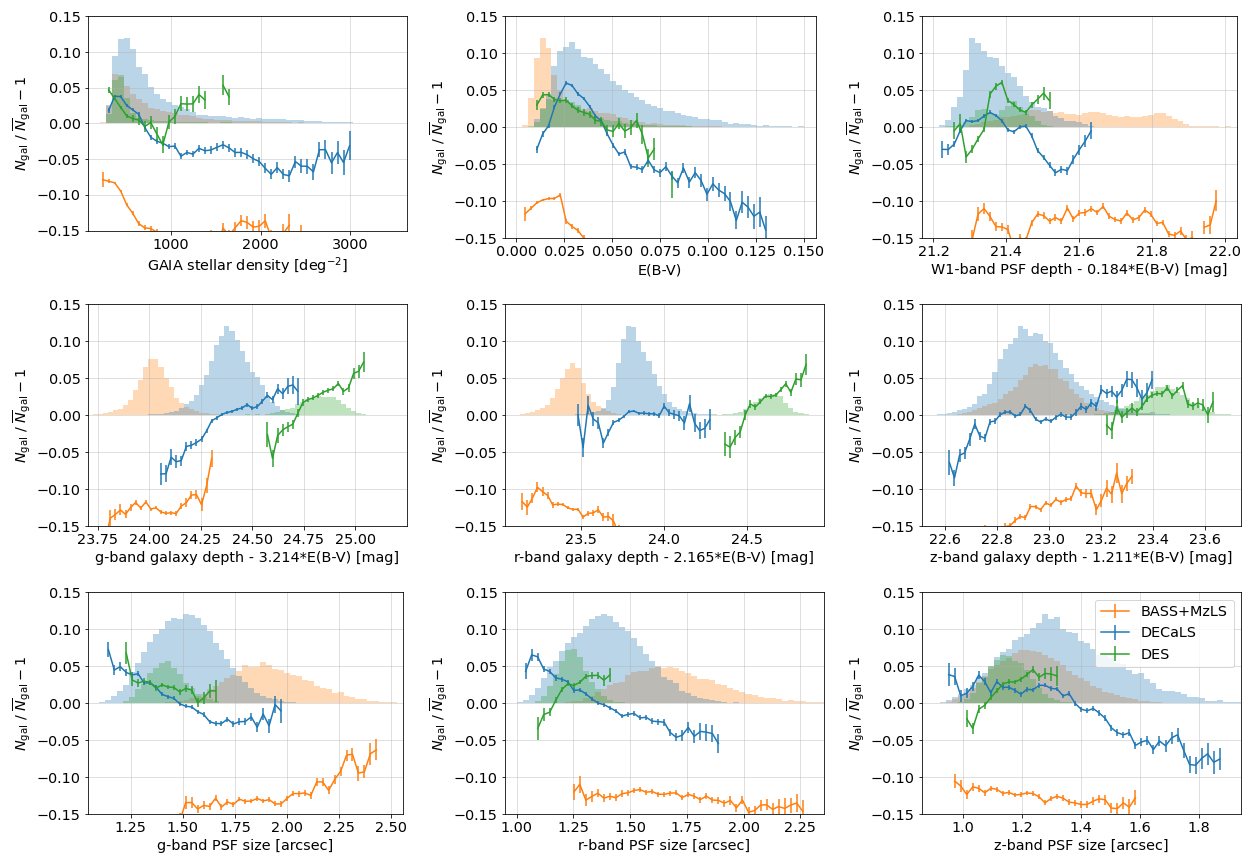

In [34]:
Image('plots/mc_corrected_elg_lop_128_ebv_corr.png')

Done! 00:00:02


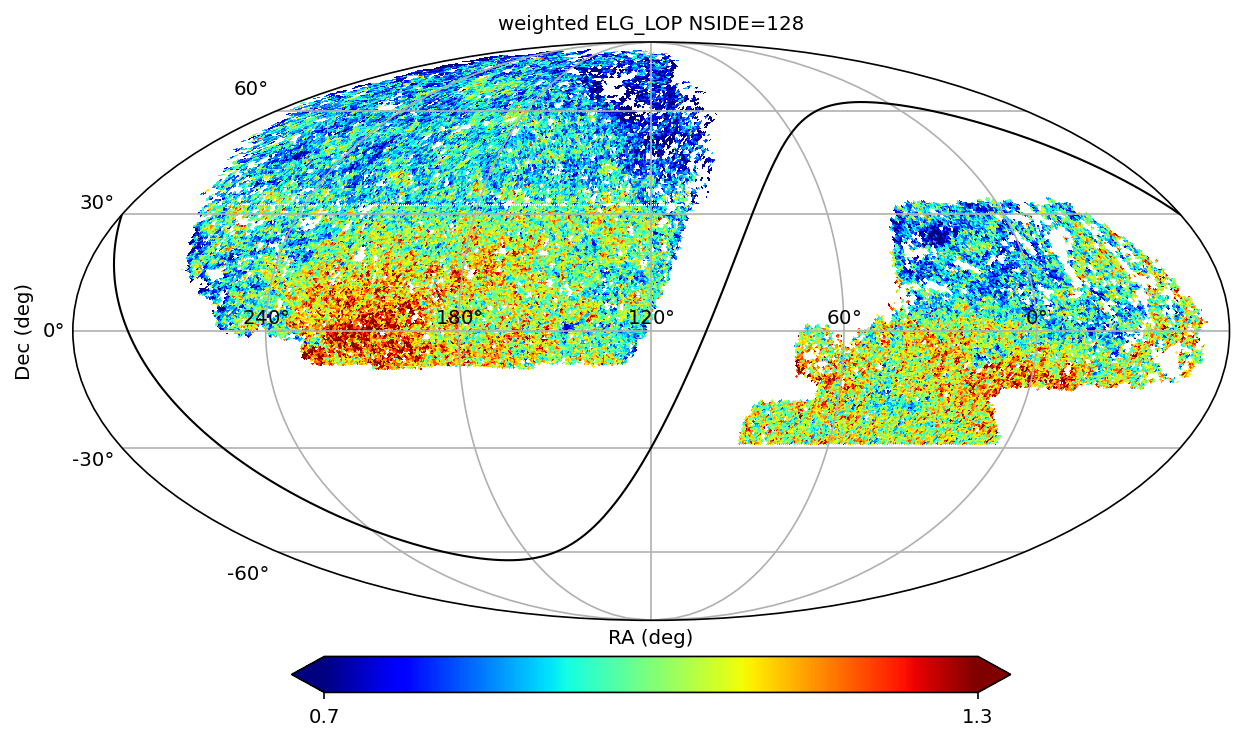

In [35]:
plot_map(nside, maps['HPXPIXEL'], maps['relative_density']/maps['mc_relative_density'],
         vmin=0.7, vmax=1.3,
         title='weighted {} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

In [36]:
mask = (maps['RA']>90) & (maps['RA']<300)
maps = maps[mask]

Done! 00:00:02


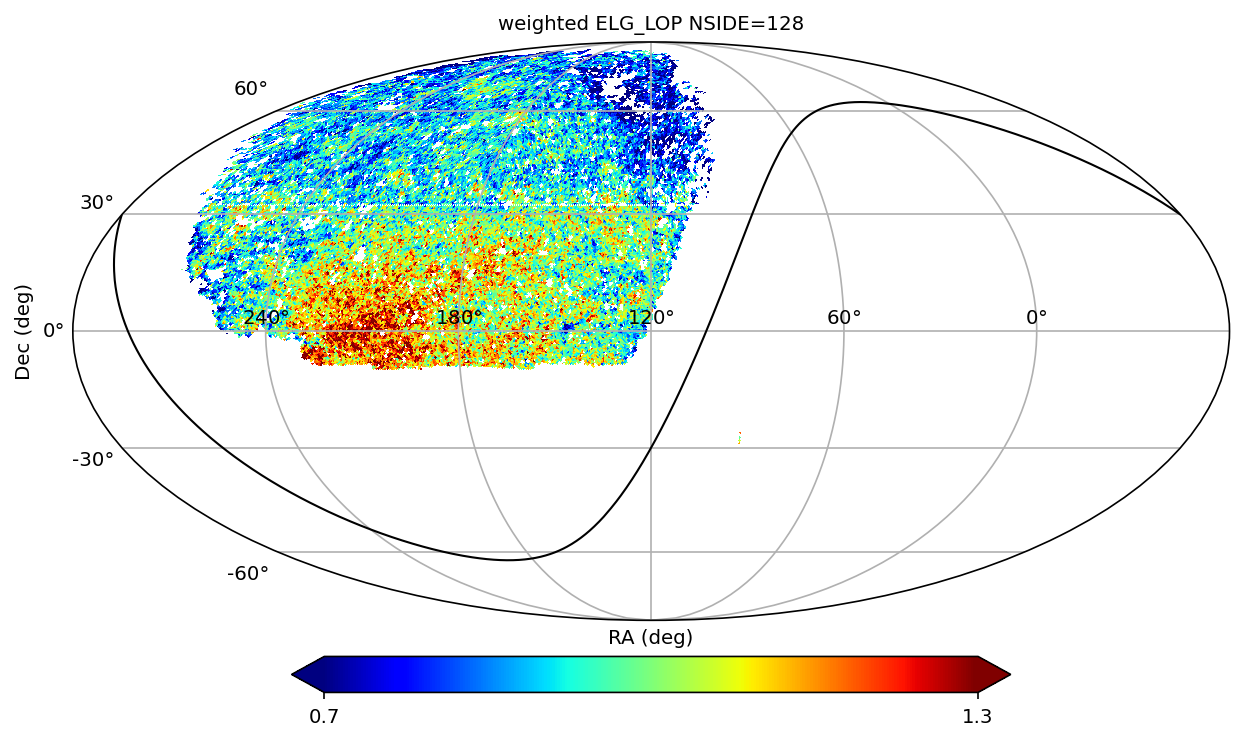

In [37]:
plot_map(nside, maps['HPXPIXEL'], maps['relative_density']/maps['mc_relative_density'],
         vmin=0.7, vmax=1.3,
         title='weighted {} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

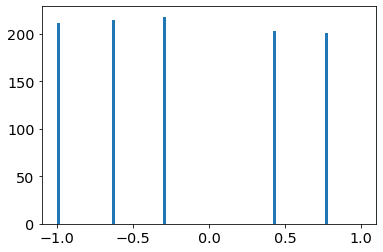

In [38]:
plt.hist(maps['DEC']-32.375, 100, range=(-1, 1));

In [39]:
mask = np.abs(maps['DEC']-32.375)<0.5
maps = maps[mask]

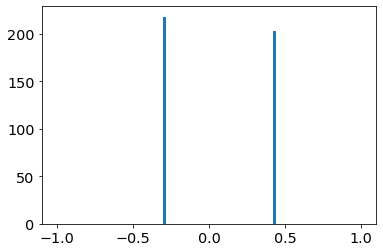

In [40]:
plt.hist(maps['DEC']-32.375, 100, range=(-1, 1));

Done! 00:00:02


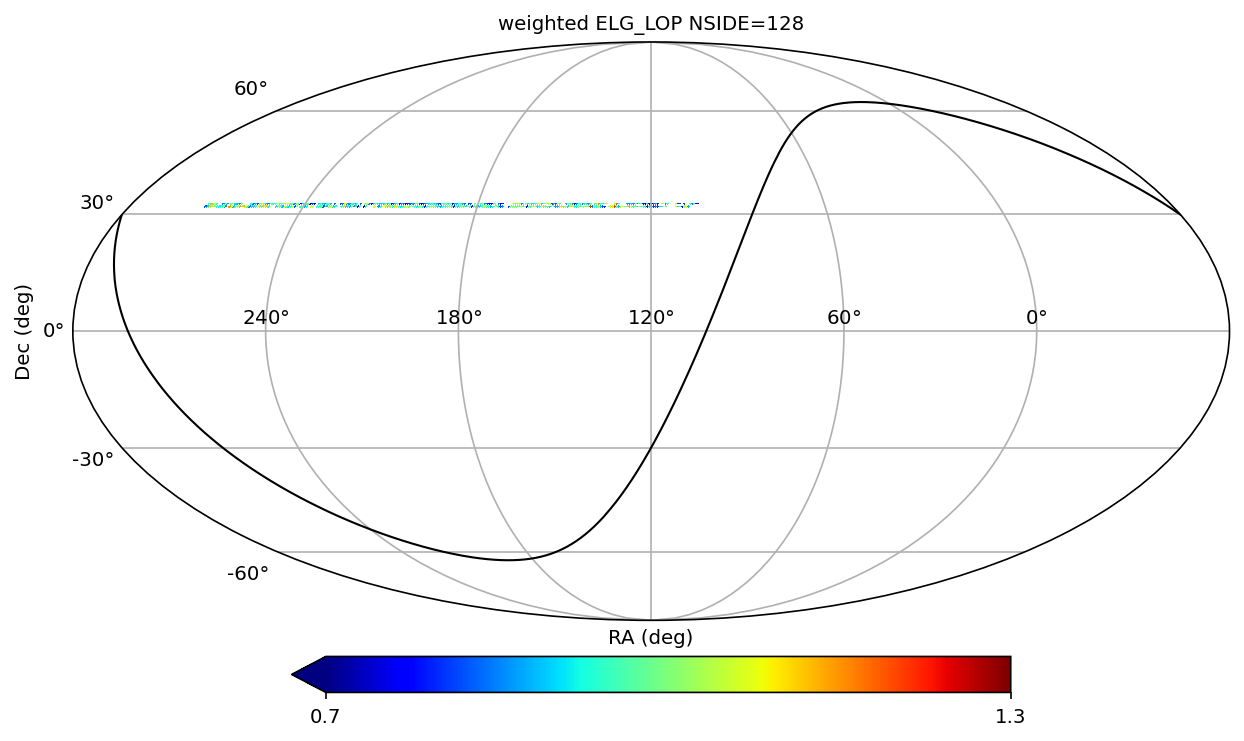

In [41]:
plot_map(nside, maps['HPXPIXEL'], maps['relative_density']/maps['mc_relative_density'],
         vmin=0.7, vmax=1.3,
         title='weighted {} NSIDE={}'.format(target_class.upper(), nside), save_path='tmp.png', show=False, xsize=1500, dpi=150)
Image("tmp.png")

In [42]:
mask_north = (maps['DEC']>=32.375)
mask_south = (~mask_north)

print(np.sum(mask_north), np.sum(mask_south))
dd = maps['relative_density']/maps['mc_relative_density']
print(np.mean(dd[mask_north]), np.mean(dd[mask_south]), 1-np.mean(dd[mask_north])/np.mean(dd[mask_south]))

203 218
0.9140042757177438 0.967979812894006 0.05576101532002975


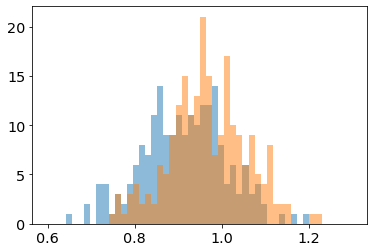

In [43]:
plt.hist(dd[mask_north], 50, range=(0.6, 1.3), alpha=0.5)
plt.hist(dd[mask_south], 50, range=(0.6, 1.3), alpha=0.5)
plt.show()

In [44]:
mask_north = (maps['DEC']>=32.375) & (maps['RA']>120) & (maps['RA']<180)
mask_south = (maps['DEC']<32.375) & (maps['RA']>120) & (maps['RA']<180)

dd = maps['relative_density']/maps['mc_relative_density']
print(np.mean(dd[mask_north]), np.mean(dd[mask_south]), 1-np.mean(dd[mask_north])/np.mean(dd[mask_south]))

0.932144676817762 0.9757979535872005 0.04473597900975457
